# Q-Learning on FrozenLake (Gymnasium)
We will use the FrozenLake-v1 environment from Gymnasium and solve it with Q-learning.


## Imports and Helpers
We import the libraries, set a random seed, and make a helper for moving averages.


In [15]:
import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# For reproducibility
SEED = 0
np.random.seed(0)

def moving_average(x, window=100):
    if len(x) < window:
        return np.array(x, dtype=float)
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[window:] - cumsum[:-window]) / float(window)

ARROWS = {0: "←", 1: "↓", 2: "→", 3: "↑"}

## Environment
We use the classic **4x4 FrozenLake** environment.  
- Start = top left  
- Goal = bottom right  
- Holes = fall in, episode ends  
- Slippery ice makes actions stochastic


In [16]:
# Classic 4x4 FrozenLake
# +1 for reaching the goal, 0 otherwise
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
n_states = env.observation_space.n
n_actions = env.action_space.n

print("Observation space:", n_states)
print("Action space:", n_actions)

Observation space: 16
Action space: 4


## Q-table and Hyperparameters
- **Q-table**: stores values for each state-action pair  
- **α (alpha)**: learning rate  
- **γ (gamma)**: discount factor  
- **ε (epsilon)**: exploration rate


In [17]:
Q = np.zeros((n_states, n_actions))

# Hyperparameters
alpha = 0.2
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
target_fraction = 0.95

episodes = 60000
max_steps_per_episode = 100

epsilon_decay = (epsilon_min/epsilon) ** (1/(episodes*target_fraction))

# Tracking
episode_rewards = []
episode_success = []
smoothed_success = []

## Epsilon-Greedy Strategy
At each step:
- With probability ε: pick a random action (explore)  
- With probability 1-ε: pick the best-known action (exploit)


In [18]:
def epsilon_greedy_action(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample() # explore
    else:
        return int(np.argmax(Q[state]))

## Training with Q-learning
For each episode:
1. Start at the beginning  
2. Choose actions with ε-greedy  
3. Update the Q-table using the Q-learning rule  
4. Decay ε over time  

We repeat for many episodes so the agent learns a good policy.


In [19]:
for ep in range(episodes):
    state, info = env.reset()
    total_reward = 0

    for t in range(max_steps_per_episode):
        action = epsilon_greedy_action(state, epsilon)

        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Q-learning update
        best_next = np.max(Q[next_state])
        td_target = reward + gamma * best_next
        td_error = td_target - Q[state, action]
        Q[state, action] += alpha * td_error 

        state = next_state
        total_reward += reward
        if done:
            break

    # Bookkeeping
    episode_rewards.append(total_reward)
    episode_success.append(1 if total_reward > 0 else 0)

    # Decay
    epsilon = max(epsilon_min, epsilon * epsilon_decay)


## Learning Curve
We plot the moving average of success rate across episodes.  
This shows if the agent is improving at reaching the goal.


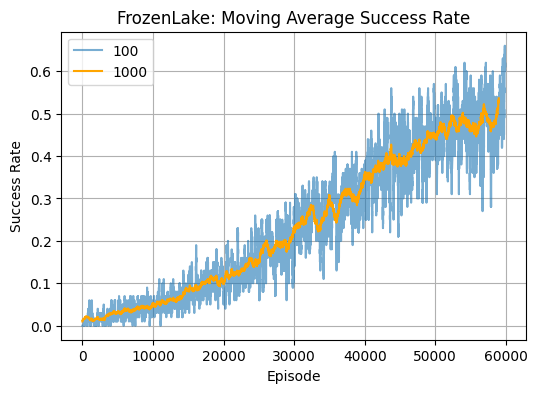

In [20]:
# Compute moving average success (window=100 and 1000)
smoothed_success_100 = moving_average(episode_success, window=100)
smoothed_success_1000 = moving_average(episode_success, window=1000)

plt.figure(figsize=(6, 4))
plt.plot(smoothed_success_100, label="100", alpha=0.6)
plt.plot(smoothed_success_1000, label="1000", color="orange")
plt.title("FrozenLake: Moving Average Success Rate")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.grid(True)
plt.legend()
plt.show()

## Greedy Policy
After training, we take the **best action** from each state (highest Q-value).  
We can display it as arrows on the grid.


In [21]:
greedy_policy = np.argmax(Q, axis=1)

def render_policy(policy):
    # 4x4 grid
    grid = []
    for s in range(n_states):
        a = policy[s]
        grid.append(ARROWS[a])
    return np.array(grid).reshape(4, 4)

render_policy(greedy_policy)

array([['←', '↑', '↑', '↑'],
       ['←', '←', '←', '←'],
       ['↑', '↓', '←', '←'],
       ['←', '→', '→', '←']], dtype='<U1')

## Evaluate Policy
We run the greedy policy without exploration to measure its success rate.


In [22]:
def evaluate_policy(env, policy, episodes=100, max_verstappen=100):
    wins = 0
    for _ in range(episodes):
        s, _ = env.reset()
        for _ in range(max_verstappen):
            a = int(policy[s])
            s, r, term, trunc, _ = env.step(a)
            if term or trunc:
                if r > 0:
                    wins += 1
                break
    return wins / episodes

eval_env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
success_rate = evaluate_policy(eval_env, greedy_policy, episodes=500)
print(f"Success rate: {success_rate * 100}%")

Success rate: 68.0%


## Watch an Episode
We let the trained agent play one episode and print the text rendering of the grid as it moves.


In [23]:
from gymnasium.wrappers import RecordVideo
from IPython.display import Video, display
from pathlib import Path

# Wrap an env for video recording
video_dir = Path("videos")
video_dir.mkdir(exist_ok=True)

env_video = gym.make(
    "FrozenLake-v1",
    map_name="4x4",
    is_slippery=True,
    render_mode="rgb_array"
)
env_video = RecordVideo(
    env_video,
    video_folder=str(video_dir),
    episode_trigger=lambda ep_id: True, # This records every episode run here
    name_prefix="frozenlake"
)

# Play one greedy episode with the learned policy and record it
# If success is rare, try a few times and stop at the first recorded episode
max_episodes_to_try = 5
for attempt in range(max_episodes_to_try):
    state, _ = env_video.reset()
    done = False
    total_reward = 0

    # Use the greedy policy learned earlier (from Q-table)
    steps = 0
    while not done and steps < 200:
        action = int(greedy_policy[state])  # exploit only
        state, reward, terminated, truncated, _ = env_video.step(action)
        done = terminated or truncated
        total_reward += reward
        steps += 1

    # Recorded the whole episode automatically
    # If you want to insist on a success you could continue the loop when total_reward == 0.
    print(f"Recorded episode {attempt+1} | total_reward={total_reward}")
    break  # remove break if you want to try multiple recordings

env_video.close()

Recorded episode 1 | total_reward=0.0


/Users/rafa/Desktop/GitHub/TTA-Class-Files/2025 Term 4/L4308T3 - Sat/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /Users/rafa/Desktop/GitHub/TTA-Class-Files/2025 Term 4/L4308T3 - Sat/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [24]:
# Find and display the most recent video
latest_video = sorted(Path("videos").glob("*.mp4"))[-1]
display(Video(str(latest_video), embed=True, width=480))

Greedy rollout return: 1.0 | success=True


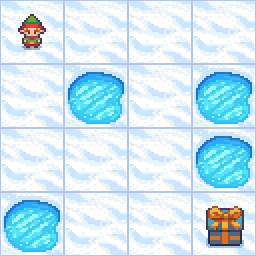

In [25]:
# Greedy rollout GIF that insists on success (retries a few times)
import imageio.v2 as imageio
from IPython.display import Image, display
import numpy as np

# check if Q-table and seed are set already
assert 'Q' in globals(), "Q-table not found. Train the agent first."
assert 'SEED' in globals(), "SEED not found. Ensure the setup cell was run."

def record_greedy_gif_win(Q, max_steps=200, seed=SEED, path="frozenlake_greedy.gif", fps=4,
                          map_name="4x4", is_slippery=True, max_attempts=5):
    env = gym.make("FrozenLake-v1", map_name=map_name, is_slippery=is_slippery, render_mode="rgb_array")

    saved_frames = None
    saved_reward = 0.0
    success = False

    for attempt in range(max_attempts):
        state, _ = env.reset(seed=seed + attempt)  # vary seed per attempt
        frames = []
        total_reward = 0.0

        for _ in range(max_steps):
            frames.append(env.render())  # capture before action for smoother playback
            action = int(np.argmax(Q[state]))
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if terminated or truncated:
                frames.append(env.render())
                break

        # Keep the first successful run; otherwise keep the latest attempt
        if total_reward > 0:
            saved_frames = frames
            saved_reward = total_reward
            success = True
            break
        elif saved_frames is None:
            saved_frames = frames
            saved_reward = total_reward

    env.close()
    imageio.mimsave(path, saved_frames, fps=fps)
    return path, saved_reward, success

gif_path, ret, ok = record_greedy_gif_win(Q, max_attempts=5, map_name="4x4", is_slippery=True)
print(f"Greedy rollout return: {ret} | success={ok}")
display(Image(filename=gif_path))


In [26]:
import pandas as pd
df = pd.DataFrame(Q, columns=["Left(0)","Down(1)","Right(2)","Up(3)"])
df.index.name = "State"
df.round(3)

,Left(0),Down(1),Right(2),Up(3)
State,,,,
0,0.546,0.531,0.529,0.532
1,0.439,0.414,0.245,0.504
2,0.444,0.403,0.405,0.470
3,0.422,0.284,0.363,0.458
4,0.562,0.495,0.287,0.490
5,0.000,0.000,0.000,0.000
6,0.418,0.113,0.217,0.145
7,0.000,0.000,0.000,0.000
8,0.433,0.530,0.522,0.591


In [27]:
grid_arrows = render_policy(greedy_policy)
for row in grid_arrows:
    print(" ".join(row))

← ↑ ↑ ↑
← ← ← ←
↑ ↓ ← ←
← → → ←
